In [1]:
import rasterio, os, glob, warnings, time
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rcParams['font.size'] = 18
import seaborn as sns

import rioxarray as rx

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.inspection import permutation_importance 

from sampling import *
from utils import *

warnings.filterwarnings("ignore")
plt.rcParams["figure.autolayout"] = True

import plotly.express as px

pd.set_option('display.max_columns',40)

In [3]:
# ca_fires = pd.read_csv('D:\Berkeley\Research\ExplainableWildfire\datasets\doi_10.6071_M3QX18__v7\Area_burned_in_each_burn_severity_class_and_emissions_per_fire_1984_2020.csv')
ca_fires = pd.read_csv('/Users/MacBookPro/Documents/Berkeley/ExplainableFire/doi_10.6071_M3QX18__v7/Area_burned_in_each_burn_severity_class_and_emissions_per_fire_1984_2020.csv')

In [4]:
ca_fires.head()

,Event_ID,Fire_Name,Lat,Long,Fire_Year,Fire_Month,Total_area_burned(ha),Unchanged(ha),Low_Severity(ha),Moderate_Severity(ha),High_Severity(ha),Grass_Burned(ha),CO2(kg),CO(kg),CH4(kg),NMOC(kg),SO2(kg),NH3(kg),NO(kg),NO2(kg),NOx(kg),PM2.5(kg),OC(kg),BC(kg)
0,CA3268211688619840421,PROCTOR,32.682,-116.886,1984,4,1222.20,0.00,300.96,691.38,229.86,0.0,8.823971e+07,5383339.56,122498.892,1334643.84,40974.4476,93153.2148,72501.624,52617.2868,116967.780,439157.412,205992.036,72591.8796
1,CA3341311687319840530,AGUANGA,33.413,-116.873,1984,5,2250.81,0.54,719.28,1209.42,321.57,0.0,1.765728e+08,10407312.81,270244.296,2652322.32,84675.1509,176318.4834,136579.959,104980.0932,215969.733,921608.307,551366.541,128230.0443
2,CA3375011772919840615,LOMA RIDGE,33.750,-117.729,1984,6,559.26,5.58,268.83,267.03,17.82,0.0,3.150790e+07,1908487.08,44565.093,476699.76,14949.4482,32872.9653,25819.893,19010.9259,41448.456,158066.550,77518.152,25344.1260
3,CA3428511755419840528,LYTLE,34.285,-117.554,1984,5,988.47,20.79,134.19,446.58,386.91,0.0,1.177670e+08,6010228.71,243621.297,1726734.24,64527.7401,91820.5767,70816.158,70530.9435,99933.183,721917.063,715550.607,42452.7525
4,CA3444311889619841015,SQUAW FLAT,34.443,-118.896,1984,10,2447.64,19.80,1748.97,607.32,71.55,0.0,1.715008e+08,9570829.41,297284.805,2563898.40,90086.0247,156232.3275,124645.644,105702.7491,189641.601,951805.737,717583.221,100634.9715


In [7]:
# Images path
img_path = '/Users/MacBookPro/Documents/Berkeley/ExplainableFire/doi_10.6071_M3QX18__v7/burn_severity_CA'
fires = os.listdir(img_path)

In [9]:
ca_fires['id'] = ca_fires['Event_ID'].apply(lambda x: x.lower())

In [10]:
paths_df = pd.DataFrame(data={'path':fires})

In [11]:
paths_df['id'] = paths_df['path'].apply(lambda x: x.split('_burn_severity_CA.tif')[0].lower())

In [12]:
ca_fires = ca_fires.merge(paths_df)

In [13]:
ca_fires.head()

,Event_ID,Fire_Name,Lat,Long,Fire_Year,Fire_Month,Total_area_burned(ha),Unchanged(ha),Low_Severity(ha),Moderate_Severity(ha),High_Severity(ha),Grass_Burned(ha),CO2(kg),CO(kg),CH4(kg),NMOC(kg),SO2(kg),NH3(kg),NO(kg),NO2(kg),NOx(kg),PM2.5(kg),OC(kg),BC(kg),id,path
0,CA3268211688619840421,PROCTOR,32.682,-116.886,1984,4,1222.20,0.00,300.96,691.38,229.86,0.0,8.823971e+07,5383339.56,122498.892,1334643.84,40974.4476,93153.2148,72501.624,52617.2868,116967.780,439157.412,205992.036,72591.8796,ca3268211688619840421,ca3268211688619840421_burn_severity_CA.tif
1,CA3268211688619840421,PROCTOR,32.682,-116.886,1984,4,1222.20,0.00,300.96,691.38,229.86,0.0,8.823971e+07,5383339.56,122498.892,1334643.84,40974.4476,93153.2148,72501.624,52617.2868,116967.780,439157.412,205992.036,72591.8796,ca3268211688619840421,ca3268211688619840421_burn_severity_CA.tif.aux...
2,CA3341311687319840530,AGUANGA,33.413,-116.873,1984,5,2250.81,0.54,719.28,1209.42,321.57,0.0,1.765728e+08,10407312.81,270244.296,2652322.32,84675.1509,176318.4834,136579.959,104980.0932,215969.733,921608.307,551366.541,128230.0443,ca3341311687319840530,ca3341311687319840530_burn_severity_CA.tif.aux...
3,CA3341311687319840530,AGUANGA,33.413,-116.873,1984,5,2250.81,0.54,719.28,1209.42,321.57,0.0,1.765728e+08,10407312.81,270244.296,2652322.32,84675.1509,176318.4834,136579.959,104980.0932,215969.733,921608.307,551366.541,128230.0443,ca3341311687319840530,ca3341311687319840530_burn_severity_CA.tif
4,CA3375011772919840615,LOMA RIDGE,33.750,-117.729,1984,6,559.26,5.58,268.83,267.03,17.82,0.0,3.150790e+07,1908487.08,44565.093,476699.76,14949.4482,32872.9653,25819.893,19010.9259,41448.456,158066.550,77518.152,25344.1260,ca3375011772919840615,ca3375011772919840615_burn_severity_CA.tif.aux...


One fire

In [14]:
fire = ca_fires.iloc[0]
path = fire['path']

In [15]:
img = rx.open_rasterio(os.path.join(img_path, path))

In [16]:
img

<xarray.DataArray (band: 1, y: 145, x: 135)>
array([[[-3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38],
        [-3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38],
        ...,
        [-3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38],
        [-3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -1.934e+06 -1.934e+06 ... -1.93e+06 -1.93e+06
  * y            (y) float64 1.283e+06 1.283e+06 ... 1.279e+06 1.279e+06
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:        4
    STATISTICS_MEAN:           2.9418262150221
    STATISTICS_MINIMUM:        2
    STATISTICS_STDDEV:         0.65645333429579
    STATISTICS_VALID_PERCENT:  69.37
    _FillValue:                -3.3999999521443642e+38
    scale_factor:              1.0
    add_offset:                0.0

Raster value 0 -- non-processing area

Raster value 1 -- unburned

Raster value 2 -- low severity

Raster value 3 -- moderate severity

Raster value 4 -- high severity 

Raster value 5 -- grass burn

In [17]:
img.rio.crs

CRS.from_epsg(5070)

In [18]:
from shapely.geometry import Polygon
def get_bbox(shp):
    xmin, ymin, xmax, ymax = shp.total_bounds
    boundary = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)])
    geoJson = {'type': 'Polygon',
     'coordinates': [[[ymin, xmin], [ymax, xmin], [ymax, xmax], [ymin, xmax]]] }
    # boundary = gpd.GeoSeries([boundary]).__geo_interface__
    return boundary, geoJson

In [19]:
xmin, ymin, xmax, ymax = img.rio.transform_bounds(
    "+init=epsg:4326",
    densify_pts=1,
)

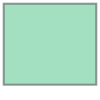

In [20]:
Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)])

In [21]:
def get_geo(path):
    img = rx.open_rasterio(os.path.join(img_path, path))
    xmin, ymin, xmax, ymax = img.rio.transform_bounds(
    "+init=epsg:4326",
    densify_pts=1,
    )

    return Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)])

In [22]:
ca_fires['geometry'] = ca_fires['path'].apply(lambda x: get_geo(x))

RasterioIOError: '/Users/MacBookPro/Documents/Berkeley/ExplainableFire/doi_10.6071_M3QX18__v7/burn_severity_CA/ca3268211688619840421_burn_severity_CA.tif.aux.xml' not recognized as a supported file format.

In [ ]:
ca_fires.head()

,Event_ID,Fire_Name,Lat,Long,Fire_Year,Fire_Month,Total_area_burned(ha),Unchanged(ha),Low_Severity(ha),Moderate_Severity(ha),...,NH3(kg),NO(kg),NO2(kg),NOx(kg),PM2.5(kg),OC(kg),BC(kg),id,path,geometry
0,CA3268211688619840421,PROCTOR,32.682,-116.886,1984,4,1222.20,0.00,300.96,691.38,...,93153.2148,72501.624,52617.2868,116967.780,439157.412,205992.036,72591.8796,ca3268211688619840421,ca3268211688619840421_burn_severity_CA.tif,"POLYGON ((-116.914085117163 32.65715356405082,..."
1,CA3341311687319840530,AGUANGA,33.413,-116.873,1984,5,2250.81,0.54,719.28,1209.42,...,176318.4834,136579.959,104980.0932,215969.733,921608.307,551366.541,128230.0443,ca3341311687319840530,ca3341311687319840530_burn_severity_CA.tif,"POLYGON ((-116.916177421544 33.38206271528966,..."
2,CA3375011772919840615,LOMA RIDGE,33.750,-117.729,1984,6,559.26,5.58,268.83,267.03,...,32872.9653,25819.893,19010.9259,41448.456,158066.550,77518.152,25344.1260,ca3375011772919840615,ca3375011772919840615_burn_severity_CA.tif,POLYGON ((-117.7476478495052 33.72471329607049...
3,CA3428511755419840528,LYTLE,34.285,-117.554,1984,5,988.47,20.79,134.19,446.58,...,91820.5767,70816.158,70530.9435,99933.183,721917.063,715550.607,42452.7525,ca3428511755419840528,ca3428511755419840528_burn_severity_CA.tif,POLYGON ((-117.5804835426337 34.25904094737259...
4,CA3444311889619841015,SQUAW FLAT,34.443,-118.896,1984,10,2447.64,19.80,1748.97,607.32,...,156232.3275,124645.644,105702.7491,189641.601,951805.737,717583.221,100634.9715,ca3444311889619841015,ca3444311889619841015_burn_severity_CA.tif,"POLYGON ((-118.936257678276 34.40777985036063,..."


In [ ]:
eco = gpd.read_file('/Users/MacBookPro/Documents/Berkeley/ExplainableFire/ca_eco_l3/ca_eco_l3.shp')
eco = eco.to_crs(4326)

In [ ]:
ca_fires = gpd.GeoDataFrame(ca_fires, crs=4326)

In [ ]:
ca_fires['% of Fire at High Severity'] = ca_fires['High_Severity(ha)']/ca_fires['Total_area_burned(ha)']
ca_fires['% of Fire at Moderate Severity'] = ca_fires['Moderate_Severity(ha)']/ca_fires['Total_area_burned(ha)']
ca_fires['% of Fire at Low Severity'] = ca_fires['Low_Severity(ha)']/ca_fires['Total_area_burned(ha)']


In [ ]:
fire_eco = gpd.sjoin(ca_fires, eco)

In [ ]:
fire_eco.columns

Index(['Event_ID', 'Fire_Name', 'Lat', 'Long', 'Fire_Year', 'Fire_Month',
       'Total_area_burned(ha)', 'Unchanged(ha)', 'Low_Severity(ha)',
       'Moderate_Severity(ha)', 'High_Severity(ha)', 'Grass_Burned(ha)',
       'CO2(kg)', 'CO(kg)', 'CH4(kg)', 'NMOC(kg)', 'SO2(kg)', 'NH3(kg)',
       'NO(kg)', 'NO2(kg)', 'NOx(kg)', 'PM2.5(kg)', 'OC(kg)', 'BC(kg)', 'id',
       'path', 'geometry', '% of Fire at High Severity',
       '% of Fire at Moderate Severity', '% of Fire at Low Severity',
       'index_right', 'US_L3CODE', 'US_L3NAME', 'NA_L3CODE', 'NA_L3NAME',
       'NA_L2CODE', 'NA_L2NAME', 'NA_L1CODE', 'NA_L1NAME', 'STATE_NAME',
       'EPA_REGION', 'L3_KEY', 'L2_KEY', 'L1_KEY'],
      dtype='object')

In [ ]:
fire_eco.shape

(2316, 44)

In [ ]:
cross_regions = fire_eco[fire_eco['Event_ID'].duplicated()]['Event_ID'].unique()
single_region = [x for x in fire_eco['Event_ID'].to_list() if x not in cross_regions]

In [ ]:
len([x for x in fire_eco['Event_ID'].to_list() if x not in cross_regions])

1128

In [ ]:
print(f'total number of fires: {ca_fires.shape[0]}')

total number of fires: 1697


In [ ]:
print(f'fires that cross ecoregions: {ca_fires.shape[0]}')

fires that cross ecoregions: 1697


In [ ]:
print(f'fires that cross ecoregions: {len(cross_regions)}')

fires that cross ecoregions: 569


In [ ]:
print(f'fires that are within the same region: {len(single_region)}')

fires that are within the same region: 1128


In [ ]:
single_region_fires = fire_eco[fire_eco['Event_ID'].isin(single_region)]
cross_region_fires = fire_eco[fire_eco['Event_ID'].isin(cross_regions)]

In [ ]:
single_region_fires['US_L3NAME'].value_counts()

Central California Foothills and Coastal Mountains     311
Southern California/Northern Baja Coast                195
Sierra Nevada                                          180
Klamath Mountains/California High North Coast Range    176
Southern California Mountains                           73
Eastern Cascades Slopes and Foothills                   49
Mojave Basin and Range                                  35
Central California Valley                               30
Central Basin and Range                                 26
Cascades                                                18
Coast Range                                             18
Sonoran Basin and Range                                 11
Northern Basin and Range                                 6
Name: US_L3NAME, dtype: int64

In [ ]:
single_region_fires.columns

Index(['Event_ID', 'Fire_Name', 'Lat', 'Long', 'Fire_Year', 'Fire_Month',
       'Total_area_burned(ha)', 'Unchanged(ha)', 'Low_Severity(ha)',
       'Moderate_Severity(ha)', 'High_Severity(ha)', 'Grass_Burned(ha)',
       'CO2(kg)', 'CO(kg)', 'CH4(kg)', 'NMOC(kg)', 'SO2(kg)', 'NH3(kg)',
       'NO(kg)', 'NO2(kg)', 'NOx(kg)', 'PM2.5(kg)', 'OC(kg)', 'BC(kg)', 'id',
       'path', 'geometry', '% of Fire at High Severity',
       '% of Fire at Moderate Severity', '% of Fire at Low Severity',
       'index_right', 'US_L3CODE', 'US_L3NAME', 'NA_L3CODE', 'NA_L3NAME',
       'NA_L2CODE', 'NA_L2NAME', 'NA_L1CODE', 'NA_L1NAME', 'STATE_NAME',
       'EPA_REGION', 'L3_KEY', 'L2_KEY', 'L1_KEY'],
      dtype='object')

In [ ]:
single_region_fires['Total_area_burned(ha)']

0        1222.20
2         559.26
24       1244.16
26       4418.01
42       3160.35
          ...   
1643      456.93
1655      808.11
1660     3559.59
1662    45117.00
1669    58078.17
Name: Total_area_burned(ha), Length: 1128, dtype: float64

In [ ]:
fig = px.scatter(single_region_fires, x='Fire_Year', y='% of Fire at High Severity', size_max=60,
                    size='Total_area_burned(ha)', color='US_L3NAME')

fig.show()

In [ ]:
single_region_fires['US_L3NAME'].unique()

array(['Southern California/Northern Baja Coast',
       'Southern California Mountains', 'Mojave Basin and Range',
       'Central California Foothills and Coastal Mountains',
       'Central California Valley', 'Sierra Nevada', 'Cascades',
       'Central Basin and Range', 'Eastern Cascades Slopes and Foothills',
       'Northern Basin and Range', 'Sonoran Basin and Range',
       'Coast Range',
       'Klamath Mountains/California High North Coast Range'],
      dtype=object)

<AxesSubplot:ylabel='Count'>

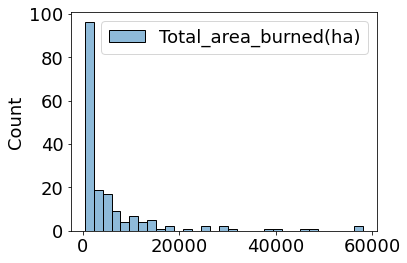

In [ ]:
sns.histplot(single_region_fires[single_region_fires['US_L3NAME']=='Klamath Mountains/California High North Coast Range'][['Total_area_burned(ha)']])

<AxesSubplot:ylabel='Count'>

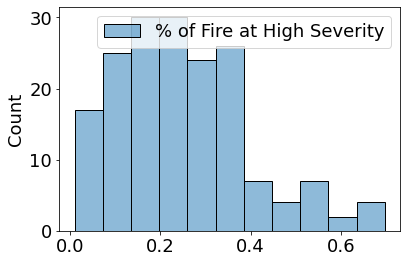

In [ ]:
sns.histplot(single_region_fires[single_region_fires['US_L3NAME']=='Klamath Mountains/California High North Coast Range'][['% of Fire at High Severity']])

<AxesSubplot:ylabel='Count'>

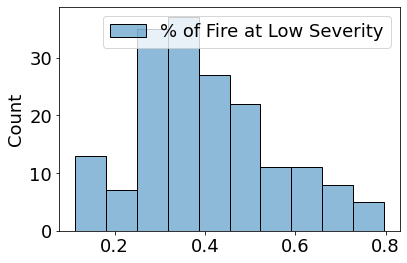

In [ ]:
sns.histplot(single_region_fires[single_region_fires['US_L3NAME']=='Klamath Mountains/California High North Coast Range'][['% of Fire at Low Severity']])

<AxesSubplot:ylabel='Count'>

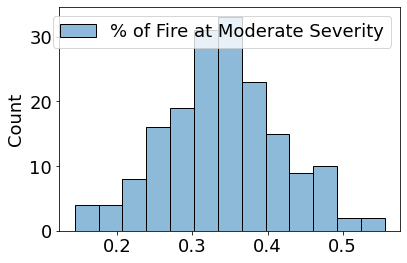

In [ ]:
sns.histplot(single_region_fires[single_region_fires['US_L3NAME']=='Klamath Mountains/California High North Coast Range'][['% of Fire at Moderate Severity']])

In [ ]:
fig = px.scatter(single_region_fires[single_region_fires['US_L3NAME']=='Mojave Basin and Range'], x='Fire_Year', y='% of Fire at High Severity', size_max=60,
                    size='Total_area_burned(ha)', color='US_L3NAME')

fig.show()



In [ ]:
px.line(single_region_fires[single_region_fires['US_L3NAME']=='Klamath Mountains/California High North Coast Range'].groupby('Fire_Year').sum()[['Total_area_burned(ha)']])

In [ ]:
px.line(single_region_fires.groupby(['Fire_Year','US_L3NAME']).count()[['Event_ID']].reset_index(),
         x='Fire_Year', y='Event_ID', color='US_L3NAME',
         width=1600, height=800)

In [ ]:
px.line(single_region_fires.groupby(['Fire_Year','US_L3NAME']).sum()[['Total_area_burned(ha)']].reset_index(),
         x='Fire_Year', y='Total_area_burned(ha)', color='US_L3NAME',
         width=1600, height=800)

In [ ]:
single_region_fires.groupby(['Fire_Year','US_L3NAME']).sum()[['Total_area_burned(ha)']].sort_values('Total_area_burned(ha)', ascending=False)

Total_area_burned(ha)
Fire_Year US_L3NAME                                                                
1987      Klamath Mountains/California High North Coast R...              155550.78
2020      Central California Foothills and Coastal Mountains              121537.62
2008      Klamath Mountains/California High North Coast R...              118183.95
          Central California Foothills and Coastal Mountains              112854.51
2017      Klamath Mountains/California High North Coast R...              108643.41
...                                                                             ...
          Northern Basin and Range                                           239.22
2013      Sonoran Basin and Range                                            232.83
2019      Central Basin and Range                                            225.45
2008      Central Basin and Range                                            138.06
2003      Sonoran Basin and Range                                             54.81

[278 rows x 1 columns]

### Largest fires are in these regions: Klamath Mountains/California High North Coast Range, Central California Foothills and Coastal Mountains

#### Klamath Mountains/California High North Coast Range

In [ ]:
temp = single_region_fires[single_region_fires['US_L3NAME']=='Klamath Mountains/California High North Coast Range']

In [ ]:
fig = px.line(single_region_fires[single_region_fires['US_L3NAME']=='Klamath Mountains/California High North Coast Range'].groupby('Fire_Year').count()['Event_ID'],
        width=800, title='Fire events by year'
        )

fig.update_layout()


In [ ]:
fig = px.bar(single_region_fires[single_region_fires['US_L3NAME']=='Klamath Mountains/California High North Coast Range'], x="Event_ID", y=[ '% of Fire at High Severity',
       '% of Fire at Moderate Severity', '% of Fire at Low Severity',], title='Klamath Mountains/California High North Coast Range')
fig.show()

In [ ]:
len(temp['Fire_Year'].unique())
temp['Fire_Year'].unique()

array([1985, 1987, 1988, 1990, 1991, 1992, 1994, 1995, 1996, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

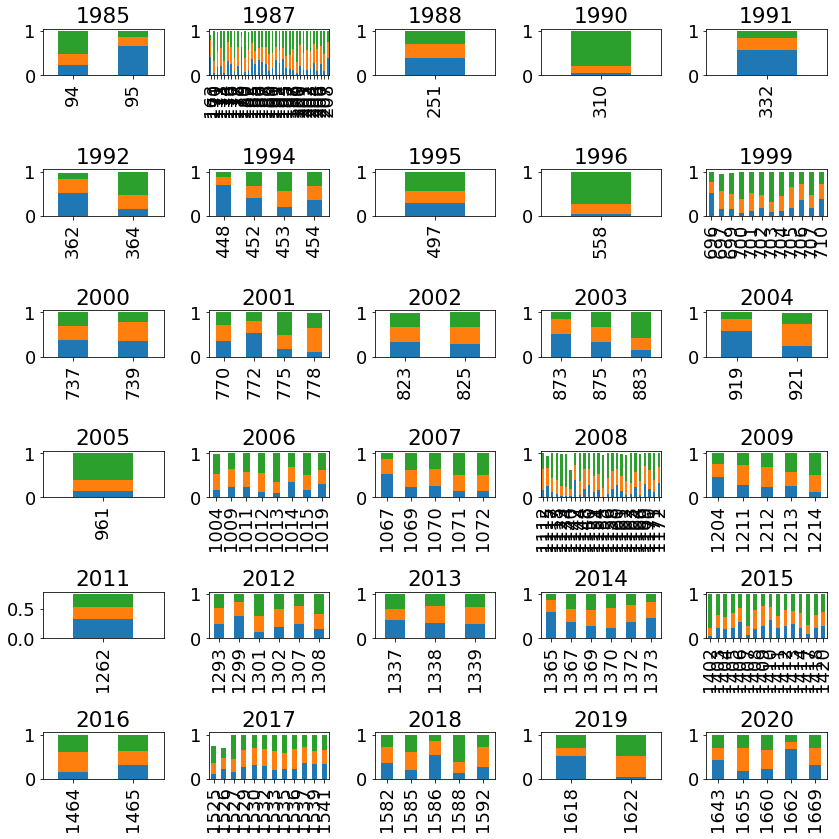

In [ ]:
rows = 6
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=[12,12])

k = 0
years = temp['Fire_Year'].unique()
for i in range(rows):
    for j in range(cols):
        year = years[k]
        _ = temp[temp['Fire_Year']==year]
        _[[ '% of Fire at High Severity',
       '% of Fire at Moderate Severity', '% of Fire at Low Severity', 'id']].plot(kind='bar', stacked=True, ax=ax[i,j], legend=False, title=year)
        k += 1

plt.show()


